In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm import tqdm_notebook
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys,psutil
from collections import Counter

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 参考
- [莫烦 RNN on Tensorflow](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-08-RNN2/#%E5%AE%9A%E4%B9%89-RNN-%E7%9A%84%E4%B8%BB%E4%BD%93%E7%BB%93%E6%9E%84)
- [莫烦 RNN on Pytorch](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-02-RNN-classification/)

# Pytorch

In [41]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter # torch 1.14 才会更新这个
import matplotlib.pyplot as plt
torch.manual_seed(1)    # reproducible

## Data Prepare

In [10]:
DOWNLOAD_MNIST = False  # 如果你已经下载好了mnist数据就写上 Fasle
root_path = "/home/zhoutong/data"

# Mnist 手写数字
# transform: 转换 PIL.Image or numpy.ndarray 成 torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
train_data = torchvision.datasets.MNIST(
    root=root_path,    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)
test_data = torchvision.datasets.MNIST(root=root_path, train=False)
train_data
test_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/zhoutong/data
    Split: Train

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/zhoutong/data
    Split: Test

torch.Size([60000, 28, 28])
torch.Size([60000])


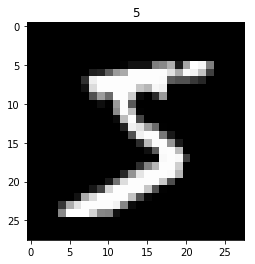

In [18]:
print(train_data.data.size())     # (60000, 28, 28)
print(train_data.targets.size())   # (60000)
_=plt.imshow(train_data.data[0].numpy(), cmap='gray')
_=plt.title('%i' % train_data.targets[0])
plt.show()

In [25]:
# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)

test_x = test_data.data.type(torch.FloatTensor)[:2000]   # shape (2000, 28, 28) 
test_x = test_x/255. # normalize to range(0,1)
test_y = test_data.targets.numpy()[:2000]    # covert to numpy array

## Model

### 超参数

In [5]:
# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 64
TIME_STEP = 28      # rnn 时间步数 / 图片高度
INPUT_SIZE = 28     # rnn 每步输入值 / 图片每行像素
LR = 0.01           # learning rate


### RNN封装

In [28]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = torch.nn.LSTM(         # if use torch.nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1st dimension. e.g. (batch, time_step, input_size)
        )

        self.out = torch.nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out


## Fit

In [29]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [31]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = torch.nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [32]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.2883 | test accuracy: 0.10
Epoch:  0 | train loss: 0.8185 | test accuracy: 0.60
Epoch:  0 | train loss: 0.8619 | test accuracy: 0.76
Epoch:  0 | train loss: 0.6205 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2627 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2186 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3307 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3876 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1891 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1416 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0623 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1515 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0547 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1727 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2030 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0713 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0867 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1881 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2081 | test accuracy

In [37]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print('pred number: ', pred_y)
print('true number: ', test_y[:10])

pred number:  [7 2 1 0 4 1 4 9 5 9]
true number:  [7 2 1 0 4 1 4 9 5 9]
